In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import tsplib95
import matplotlib.pyplot as plt
import plotnine as p9
import json

from ortools.linear_solver import pywraplp
from pathlib import Path
np.set_printoptions(threshold=np.inf)

In [16]:
def plot_solution(solution, n):
    S = nx.from_numpy_array(np.array(solution).reshape(n, n))
    pos = nx.spectral_layout(S)
    nx.draw(S, pos)
    nx.draw_networkx_labels(S, pos)

In [17]:
class ATSP:
    def __init__(self, formulation="SSB", linear_relaxation=False):

        self.formulation = formulation
        self.linear_relaxation = linear_relaxation
        self.status = None
        self.objective = None
        self.solve_time =None
        self.solution = None
        self.n = None
        self.C = None
        self.name = None

    def read(self, path):

        problem = tsplib95.load(path)
        G = problem.get_graph()
        self.name = problem.name
        self.C = nx.to_numpy_array(G)
        self.n = len(self.C)
        return self

    def save(self, dir):

        problem_solution = {
            "formulation": self.formulation,
            "name": self.name,
            "linear_relaxation": self.linear_relaxation,
            "n": self.n,
            "status": self.status,
            "objective": self.objective,
            "solve_time": self.solve_time,
            "solution": self.solution,
        }

        kind = ["integer", "linear_relaxation"][self.linear_relaxation]
             
        filename = dir + "_".join([self.name, self.formulation, kind]) + ".json"

        with open(filename, "w") as f:
            json.dump(problem_solution, f) 
                
        return self

    def solve(self):

        s = pywraplp.Solver.CreateSolver(self.formulation, "CBC")

        inf = s.infinity()

        if self.linear_relaxation:
            x = [[s.NumVar(0, 1, f"x[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]
        else:
            x = [[s.BoolVar(f"x[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]

        for i in range(self.n):
            s.Add(1 == s.Sum(x[i][j] for j in range(self.n)))
            s.Add(1 == s.Sum(x[j][i] for j in range(self.n)))
            #s.Add(0 == x[i][i])

        if self.formulation == "MTZ":

            u = [s.NumVar(0, inf, f"u[{i}]") for i in range(self.n)]

            for i in range(1, self.n):
                for j in range(1, self.n):
                    s.Add(u[i] - u[j] + (self.n - 1) * x[i][j] <= self.n - 2)
                    
        else:

            d = [[s.NumVar(0, inf, f"d[{i}, {j}]") for i in range(self.n)] for j in range(self.n)]

            for i in range(1, self.n):
                for j in range(1, self.n):
                    s.Add(d[i][j] - x[i][j] >= 0)
                    if i != j:
                        s.Add(d[i][j] + d[j][i] == 1)

            for i in range(1, self.n):
                for j in range(1, self.n):
                    for k in range(1, self.n):
                        s.Add(x[i][j] + d[j][k] + x[k][j] + d[k][i] + x[i][k] <= 2)

            for j in range(1, self.n):
                s.Add(x[0][j] + x[j][0] <= 1)

        s.Minimize(s.Sum(self.C[i][j] * x[i][j] for i in range(self.n) for j in range(self.n)))
        s.SetNumThreads(3) # diminuir se necessario

        if not self.linear_relaxation:
            s.set_time_limit(7200000)
        
        self.status = s.Solve()
        self.objective = s.Objective().Value()
        self.solve_time = s.wall_time()
        self.solution = [x[i][j].solution_value() for i in range(self.n) for j in range(self.n)]

        return self

# Branch And Bound 

In [18]:
# lendo dados da instancia BR17
C = ATSP("MTZ", linear_relaxation=True).read("data/ftv33.atsp").C
n = len(C)

In [19]:
n

34

In [35]:
from tabulate import tabulate

def branch(restr_list):

    s = pywraplp.Solver.CreateSolver("SSB", "CBC")
    x = [[s.NumVar(0, 1, f"x[{i}, {j}]") for i in range(n)] for j in range(n)]

    inf = s.infinity()

    for i in range(n):
        s.Add(1 == s.Sum(x[i][j] for j in range(n)))
        s.Add(1 == s.Sum(x[j][i] for j in range(n)))

    d = [[s.NumVar(0, inf, f"d[{i}, {j}]") for i in range(n)] for j in range(n)]
      
    for i in range(1, n):
        for j in range(1, n):
            s.Add(d[i][j] - x[i][j] >= 0)
            if i != j:
                s.Add(d[i][j] + d[j][i] == 1)

    if restr_list:
        for i, j, k in restr_list:
            s.Add(x[i][j] == k)

    s.Minimize(s.Sum(C[i][j] * x[i][j] for i in range(n) for j in range(n)))

    status = s.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print("Solução Viavel")
        print("Lower Bound", s.Objective().Value())
        solucao = np.array([x[i][j].solution_value() for i in range(n) for j in range(n)])
        is_integer = np.all([i in [0, 1] for i in solucao])
        print("Solução é inteira?", is_integer)
        print(tabulate(solucao.reshape(n, n)))

In [36]:
branch([(0,1,0), (0,12,1), (1,2,0)])

Solução Viavel
Lower Bound 1221.0
Solução é inteira? True
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  1  

In [30]:
status = s.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print("Solução viavel")
    print("Lower Bound", s.Objective().Value())
    np.array([x[i][j].solution_value() for i in range(n) for j in range(n)]).reshape(n, n)

Solução viavel 2.25


In [35]:
s.Add(x[1][10] == 1) # adicionar restricoes ate fazer uma poda por otimalidade
status = s.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print("Solução viavel")
    print("Lower Bound", s.Objective().Value())
    np.array([x[i][j].solution_value() for i in range(n) for j in range(n)]).reshape(n, n)

Solução viavel 2.2500000000000013


# Comparision

In [1]:
dat_files = Path("data").glob("*.atsp")

for f in sorted(dat_files):
    ATSP("MTZ", linear_relaxation=True).read(f).solve().save("solutions/")
    ATSP("SSB", linear_relaxation=True).read(f).solve().save("solutions/")
    ATSP("MTZ").read(f).solve().save("solutions/")
    ATSP("SSB").read(f).solve().save("solutions/")

NameError: name 'Path' is not defined

In [41]:
# lendo as soluções para plotar grafico
sol_files = Path("solutions").glob("*json")

solutions = {}
for f in sol_files:
    with open(f, "r") as file:
        solutions[str(f)] = json.load(file)

solutions = pd.DataFrame(solutions).T
#.assign(solve_time=lambda df: df["solve_time"] / (1000*60*60)))
#sol_df["solve_time"] = sol_df["solve_time"].astype("float").round(4)

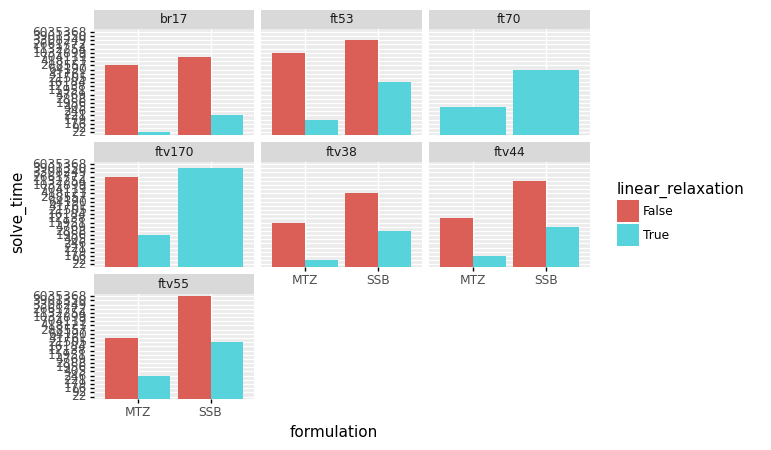

<ggplot: (8746497971305)>

In [42]:
(p9.ggplot(solutions) +
    p9.aes("formulation", "solve_time", fill="linear_relaxation") +
    p9.geom_col(position="dodge") +
    p9.facet_wrap("name"))

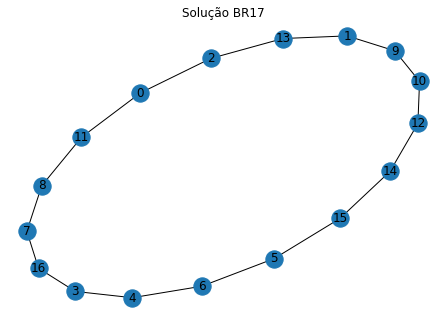

In [13]:
br17_sol = solutions['solutions/br17_SSB_integer.json']
plot_solution(br17_sol["solution"], br17_sol['n'])
plt.title("Solução BR17");